## Figures for 'A review of Bayesian perspectives on sample size derivation for confirmatory trials'

The following notebook contains all code required to reproduce the figures in the manuscript.

In [1]:
suppressPackageStartupMessages(library(tidyverse))

source("../R/priors.R")
source("../R/functions.R")

## Comparison of required sample sizes for various prior choices (Figure 2)

We start by defining a baisc parameters for the situation we look at, like maximal type one error rate etc.

In [2]:
# maximal sample size cut-off
nmax             <-  1000
# one sided maximal type one error rate
alpha            <- 0.025
# minimal power/expected power/probability of success is 1 - beta
beta             <- 0.2
# upper boundary of the null hypothesis for the location parameter
# H0: theta <= theta_null
theta_null       <- 0.0
# minimal clinically important difference (MCID)
theta_mcid       <- 0.1

Next, we define the range of prior (hyper)parameters to look at. We consider truncated normal priors (maximal entropy given mean/variance on compact interval).

In [3]:
prior_lo         <- -0.3
prior_hi         <-  0.7
# range of prior means for location parameter
prior_mean_range <- seq(prior_lo, prior_hi, by = .01)
# range of prior standard deviations for location parameter
prior_sd_range   <- seq(.01, 1, by = .01)

We can then evaluate the respective required sample sizes for the different approaches depending on the prior mean and standard deviation.
See `R/priors.R` and `R/functions.R` for details.

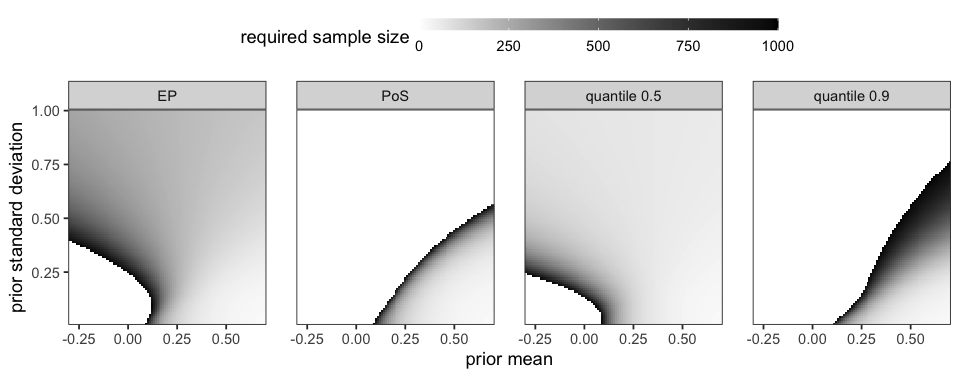

In [4]:
# adjust plot output size
options(repr.plot.width = 8, repr.plot.height = 3.15)

# create 2d grid of prior mean/sd combinations
expand_grid(
    mu  = prior_mean_range,
    tau = prior_sd_range
) %>%
# compute the required sample sizes
mutate(
    prior          = map2(mu, tau, ~Normal(.x, .y, lo = prior_lo, hi = prior_hi)),
    `quantile 0.5` = map_dbl(prior, ~get_n_quantile(theta_null, ., .5, pwr = 1 - beta, alpha = alpha, upper_n = nmax)),
    `quantile 0.9` = map_dbl(prior, ~get_n_quantile(theta_null, ., .9, pwr = 1 - beta, alpha = alpha, upper_n = nmax)),
    EP             = map_dbl(prior, ~get_n_ep(theta_null, ., pwr = 1 - beta, alpha = alpha, upper_n = nmax)),
    PoS            = map_dbl(prior, ~get_n_pos(theta_null, ., pwr = 1 - beta, alpha = alpha, upper_n = nmax))
) %>%
pivot_longer(
    c(contains('quantile'), EP, PoS),
    values_to = 'required sample size',
    names_to  = 'criterion'
) %>%
filter(
    `required sample size` <= nmax, # make sure maximal sample size is respected
    !is.na(`required sample size`)  # throw out instances where the maximal sample size boundary was hit
) %>%
# plot
ggplot() +
    aes(mu, tau, fill = `required sample size`, z = `required sample size`) +
    geom_raster() + # geom_raster leads to some pdf viewers interpolating, do not want that!
    scale_fill_gradient(limits = c(0, 1000), low = '#FFFFFF', high = '#000000') +
    guides(
        fill = guide_colorbar("required sample size",
                              barwidth  = grid::unit(15, "lines"),
                              barheight = grid::unit(.5, "lines")
            )
    ) +
    coord_cartesian(expand = FALSE) +
    xlab('prior mean') +
    ylab('prior standard deviation') +
    facet_wrap(~criterion, nrow = 1) +
    theme_bw() +
    theme(
        panel.grid      = element_blank(),
        panel.spacing   = unit(1.25, 'lines'),
        legend.position = 'top'
    )

In [5]:
# save plot as pdf
ggsave("../latex/figures/fig2-required-sample-size-comparison.pdf", width = 8, height = 3.15)

## Probability of success as the basis for sample size derivation (Figure 3)

In [6]:
# function to compute all parts of PoS'
PoS_all <- function(prior, n, c, null = 0, mrv = null) {
    part1 <- integrate(
        function(Delta) pdf(prior, Delta) * power(Delta, n, c), prior$lower, null
    )$value
    part2 <- integrate(
        function(Delta) pdf(prior, Delta) * power(Delta, n, c), null, mrv
    )$value
    part3 <- integrate(
        function(Delta) pdf(prior, Delta) * power(Delta, n, c), mrv, prior$upper
    )$value
    return(tibble(a = part1, b = part2, c = part3))
}

We now plot the relative composition of PoS' for varying prior mean and standard deviation.

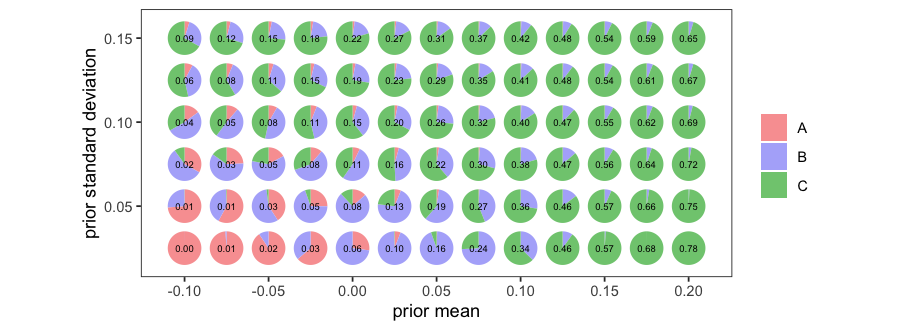

In [7]:
# adjust plot output size
options(repr.plot.width = 7.5, repr.plot.height = 2.75)

expand_grid(
    prior_mean = seq(-0.1, .2, .025),
    prior_sd   = seq(.025, .15, .025)
) %>%
mutate(
    tmp = pmap(
        list(prior_mean, prior_sd),
        ~PoS_all(
            Normal(..1, ..2, -.3, .7),
            150,
            qnorm(1 - .05),
            mrv = theta_mcid)
    )
) %>%
unnest(tmp) %>%
mutate(
       id = row_number(),
    total = a + b + c,
        A = a/total,
        B = b/total,
        C = c/total
) %>% {
ggplot(.) +
    scatterpie::geom_scatterpie(
        aes(x = prior_mean, y = prior_sd, group = id, r = .01),
        data = ., cols = c("A", "B", "C"), color = NA
    ) +
    geom_text(
        aes(x = prior_mean, y = prior_sd, label = sprintf("%.2f", total)),
        size = 2
    ) +
    theme_bw() +
    coord_equal() +
    scale_x_continuous("prior mean", breaks = seq(-.2, .3, .05)) +
    scale_y_continuous("prior standard deviation", breaks = seq(0.05, .25, .05)) +
    scale_fill_manual("",
        values = c(
            A = scales::muted("red", l = 75, c = 60),
            B = scales::muted("blue", l = 75, c = 60),
            C = scales::muted("green", l = 75, c = 60)
        )
    ) +
    theme(
        legend.position = "right",
        panel.grid      = element_blank()
    )}

In [8]:
ggsave("../latex/figures/fig3-pos-prime-composition.pdf", width = 7.5, height = 2.75)

## Distribution of random power under a constraint on expected power (Figure 4)

We now look at three particular situations with the following prior means and standard deviations:

In [9]:
# prior configurations to look at
tbl_poi <- tibble(
         mu = c(-.25, .3, .5),
        tau = c(.4, .125, .05)
    ) %>%
    mutate(
        prior = map2(mu, tau, ~Normal(..1, ..2, prior_lo, prior_hi)),
        n     = map_dbl(prior, ~get_n_ep(theta_null, ., theta_mcid, 1 - beta, alpha)),
        label = sprintf("mean=%.2f, sd=%.2f, n=%i", mu, tau, round(n))
    )

tbl_poi %>% 
    select(label, n)

label,n
<chr>,<dbl>
"mean=-0.25, sd=0.40, n=172",172
"mean=0.30, sd=0.12, n=109",109
"mean=0.50, sd=0.05, n=33",33


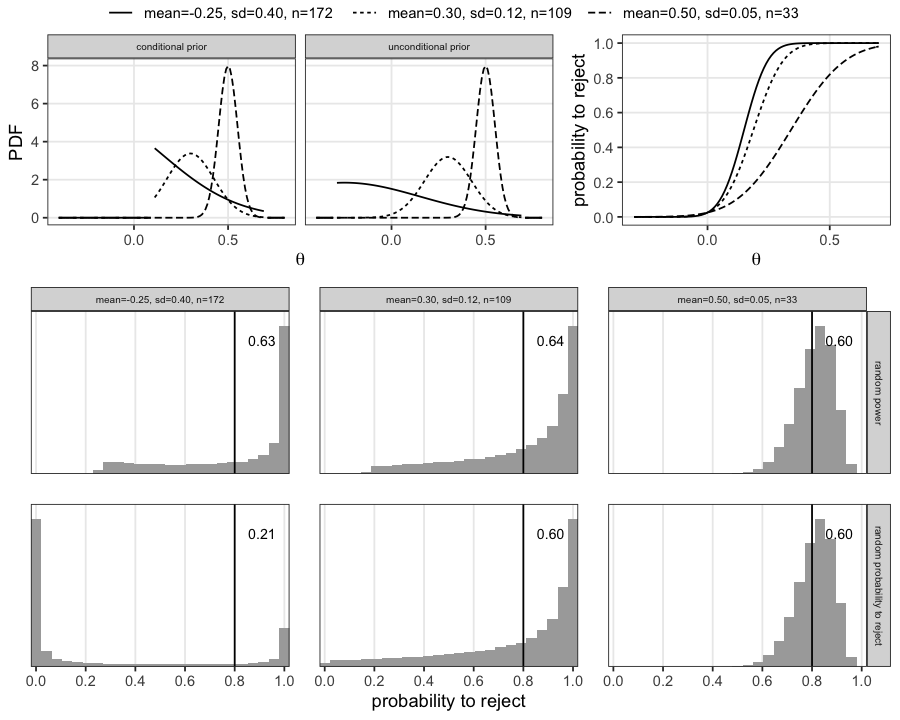

In [10]:
# adjust plot output size
options(repr.plot.width = 7.5, repr.plot.height = 6)

plt_priors <- tbl_poi %>%
    mutate(
        tmp = map(prior, ~tibble(
                theta = seq(prior_lo - 0.1, prior_hi + 0.1, .01),
                `unconditional prior`   = pdf(., theta) %>%
                    {ifelse(theta == theta[which.min(abs(prior_lo - theta))] | (theta == theta[which.min(abs(prior_hi - theta))]), NA_real_, .)},
                `conditional prior` = pdf(condition(., lo = theta_mcid), theta) %>%
                    {ifelse(theta == theta[which.min(abs(theta_mcid - theta))] | (theta == theta[which.min(abs(prior_hi - theta))]), NA_real_, .)}
            )
        )
    ) %>%
    unnest(tmp) %>%
    pivot_longer(c(`conditional prior`, `unconditional prior`)) %>%
    ggplot(aes(theta, value, linetype = label)) +
        geom_line() +
        facet_wrap(~name) +
        scale_linetype_discrete("prior") +
        scale_x_continuous(expression(theta)) +
        scale_y_continuous("PDF") +
        theme_bw() +
        theme(
            legend.position  = "top",
            panel.grid.minor = element_blank(),
            strip.text       = element_text(size = 6)
        )

plt_power_curves <- full_join(
        tbl_poi,
        expand_grid(
            theta = seq(prior_lo, prior_hi, by = 0.01),
            n = tbl_poi$n
        ),
        by = "n"
    ) %>%
    mutate(
        power = map2_dbl(theta, n, ~power(..1, ..2, qnorm(1 - alpha)))
    ) %>%
    ggplot() +
    aes(theta, power, linetype = label) +
    geom_line() +
    scale_color_discrete("") +
    scale_x_continuous(expression(theta), breaks = c(0, 0.5)) +
    scale_y_continuous("probability to reject", breaks = seq(0, 1, .2)) +
    scale_linetype("") +
    theme_bw() +
    theme(
        panel.grid.minor = element_blank(),
        legend.position = "top"
    )

set.seed(42)
tbl_samples <- tbl_poi %>%
    mutate(
        unconditional = map(prior, ~get_sample(., 1e5)),
        conditional   = map(prior, ~get_sample(condition(., lo = theta_mcid), 1e5))
    ) %>%
    unnest(c(conditional, unconditional)) %>%
    pivot_longer(c(conditional, unconditional), names_to = "type", values_to = "rtheta") %>%
    mutate(
        power  = map2_dbl(rtheta, n, ~power(..1, ..2, qnorm(1 - alpha)))
    )

tbl_probs <- tbl_samples %>%
    group_by(label, type) %>%
    summarise(
        tmp   = mean(power >= 1 - beta),
          power = 1 - beta,
        .groups = "drop"
    )

plt_power_distribution <- tbl_samples %>%
    mutate(
        type = ifelse(type == "conditional",
            "random power",
            "random probability to reject"
        )
    ) %>%
    ggplot(aes(power)) +
        geom_histogram(aes(y = stat(ndensity)), bins = 25, fill = "darkgray") +
        geom_vline(aes(xintercept = 0.8), color = "black") +
        geom_text(
            aes(
                label = sprintf("%.2f", tmp),
            ),
            y     = .9,
            x     = 0.91,
            size  = 3,
            color = "black",
            data  = tbl_probs %>%
                mutate(
                    type = ifelse(type == "conditional",
                                  "random power",
                                  "random probability to reject"
                    )
                )
        ) +
        scale_y_continuous("", breaks = c(), limits = c(0, 1.1)) +
        scale_x_continuous("probability to reject", breaks = seq(0, 1, .2)) +
        coord_cartesian(expand = FALSE) +
        facet_grid(type ~ label, scales = "free_y") +
        theme_bw() +
        theme(
            panel.grid.minor = element_blank(),
            panel.spacing    = unit(1.25, "lines"),
            strip.text       = element_text(size = 6)
        )

legend <- cowplot::get_legend(plt_power_curves)

cowplot::plot_grid(
    legend,
    cowplot::plot_grid(
        plt_priors + theme(legend.position = "none"),
        plt_power_curves + theme(legend.position = "none"),
        rel_widths = c(2, 1.2),
        nrow = 1
    ),
    plt_power_distribution,
    rel_heights = c(.1, 1, 1.75),
    ncol = 1
)

In [11]:
ggsave("../latex/figures/fig4-power-distribution-ep-approach.pdf", width = 7.5, height = 6)

## Distribution of random power under quantile approach (Figure 5)

We now restrict the analysis to a single prior configuration and explore the sensitivity of the prior-quantile approach towards the choice of $\gamma$ and $\beta$.

In [12]:
prior <- Normal(0.3, 0.2, prior_lo, prior_hi)

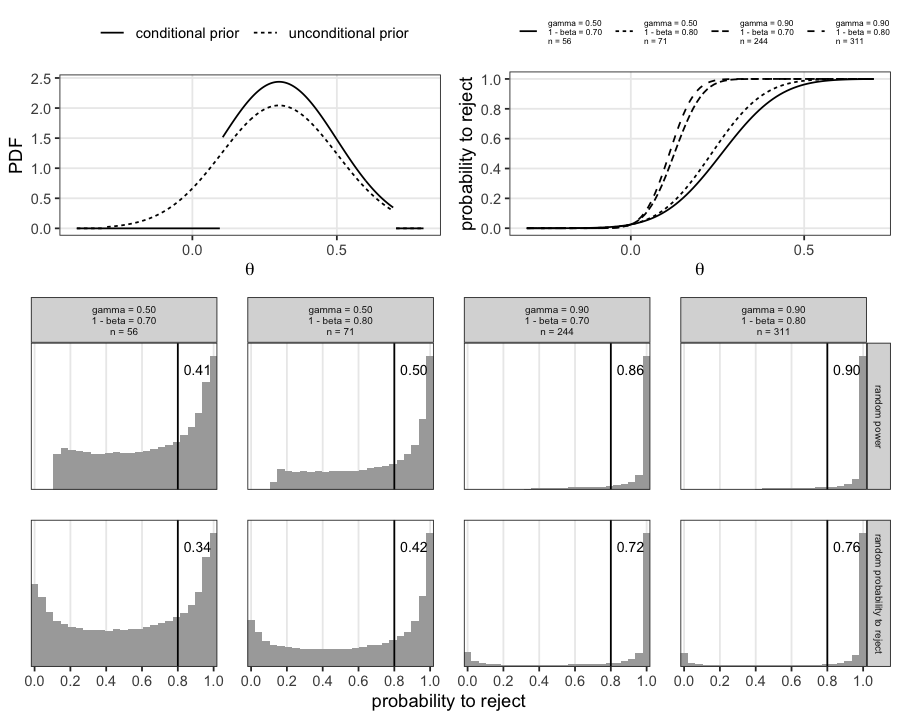

In [13]:
# adjust plot output size
options(repr.plot.width = 7.5, repr.plot.height = 6)

# plot conditional and unconditional priors
plt_priors <- tibble(
        mu = .3,
        tau = .2,
        prior = list(Normal(.3, .2, lo = prior_lo, hi = prior_hi)),
        label = sprintf("mean=%.2f, sd=%.2f", mu, tau)
    ) %>%
    mutate(
        tmp = map(prior, ~tibble(
            theta = seq(prior_lo - 0.1, prior_hi + 0.1, .005),
            `unconditional prior`   = pdf(., theta) %>%
                {ifelse(theta == theta[which.min(abs(prior_lo - theta))] | (theta == theta[which.min(abs(prior_hi - theta))]), NA_real_, .)},
            `conditional prior` = pdf(condition(., lo = theta_mcid), theta) %>%
                {ifelse(theta == theta[which.min(abs(theta_mcid - theta))] | (theta == theta[which.min(abs(prior_hi - theta))]), NA_real_, .)}
        )
        )
    ) %>%
    unnest(tmp) %>%
    pivot_longer(c(`conditional prior`, `unconditional prior`)) %>%
    ggplot(aes(theta, value, linetype = label)) +
    geom_line(aes(linetype = name)) +
    scale_x_continuous(expression(theta)) +
    scale_y_continuous("PDF") +
    scale_linetype_discrete("") +
    theme_bw() +
    theme(
        legend.position  = "top",
        panel.grid.minor = element_blank()
    )

tbl_gamma <- expand_grid(
               gamma = c(.5, .9),
        target_power = c(0.7, 0.8)
    ) %>%
    mutate(
        n     = map2_dbl(
            gamma,
            target_power,
            ~get_n_quantile(theta_null, prior, ..1, theta_mcid, ..2, alpha)),
        label = sprintf("gamma = %.2f\n1 - beta = %.2f\nn = %i", gamma, target_power, round(n))
    )


plt_power_curves <- full_join(
        tbl_gamma,
        expand_grid(
            theta = seq(prior_lo, prior_hi, by = 0.01),
            n = tbl_gamma$n
        ),
        by = "n"
    ) %>%
    mutate(
        power = map2_dbl(theta, n, ~power(..1, ..2, qnorm(1 - alpha)))
    ) %>%
    ggplot() +
    aes(theta, power, linetype = label) +
    geom_line() +
    scale_linetype_discrete("", guide = guide_legend(nrow = 1)) +
    scale_x_continuous(expression(theta), breaks =c(0, 0.5)) +
    scale_y_continuous("probability to reject", breaks = seq(0, 1, .2)) +
    theme_bw() +
    theme(
        panel.grid.minor = element_blank(),
        legend.position = "top",
        legend.text     = element_text(size = 5),
        legend.key.size = unit(0.9,"line")
    )


set.seed(42)
tbl_samples <- tbl_gamma %>%
    mutate(
        `random probability to reject` = map(gamma, ~get_sample(prior, 1e5)),
        `random power` = map(gamma, ~get_sample(condition(prior, lo = theta_mcid), 1e5))
    ) %>%
    unnest(c(`random probability to reject`, `random power`)) %>%
    pivot_longer(
        c(`random probability to reject`, `random power`),
        names_to = "type",
        values_to = "rtheta"
    ) %>%
    mutate(
        power  = map2_dbl(rtheta, n, ~power(..1, ..2, qnorm(1 - alpha)))
    )

tbl_probs <- tbl_samples %>%
    group_by(label, type) %>%
    summarise(
            tmp = mean(power >= 1 - beta),
          power = 1 - beta,
        .groups = "drop"
    )

plt_power_distribution <- tbl_samples %>%
    ggplot(aes(power)) +
    geom_histogram(aes(y = stat(ndensity)), bins = 25, fill = "darkgray") +
    geom_vline(aes(xintercept = 0.8), color = "black") +
    geom_text(
        aes(
            label = sprintf("%.2f", tmp),
        ),
        y     = .9,
        x     = 0.91,
        size  = 3,
        color = "black",
        data  = tbl_probs
    ) +
    scale_y_continuous("", breaks = c(), limits = c(0, 1.1)) +
    scale_x_continuous("probability to reject", breaks = seq(0, 1, .2)) +
    coord_cartesian(expand = FALSE) +
    facet_grid(type ~ label, scales = "free_y") +
    theme_bw() +
    theme(
        panel.grid.minor = element_blank(),
        panel.spacing    = unit(1.25, "lines"),
        strip.text       = element_text(size = 6)
    )

legend_priors <- cowplot::get_legend(plt_priors)
legend_pwr    <- cowplot::get_legend(plt_power_curves)

cowplot::plot_grid(
    cowplot::plot_grid(
        plt_priors , plt_power_curves,
        rel_widths = c(1, 1)
    ),
    plt_power_distribution,
    rel_heights = c(1, 1.5),
    ncol = 1
)

In [14]:
ggsave("../latex/figures/fig5-power-distribution-quantile-approach.pdf", width = 7.5, height = 6)

##  A clinical trial example / utility matching (Figures 6 + 7)

In [29]:
prior            <- Normal(0.2, 0.2, -0.3, 0.7)
# minimal clinically important difference (MCID)
theta_mcid       <- 0.05

tranformed_prior_pdf <- function(hr) {
    pdf(prior, -log(hr))/hr
}

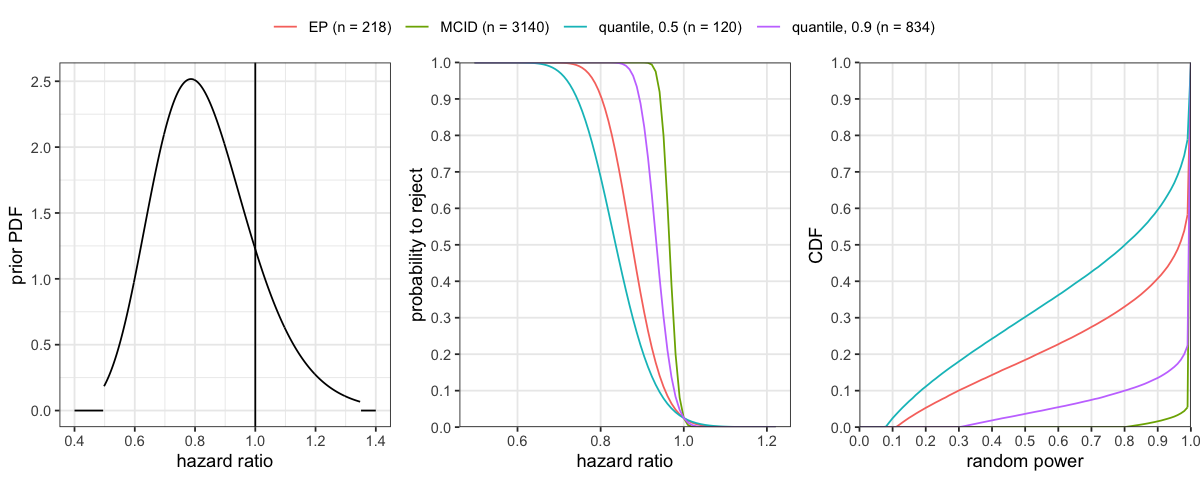

In [55]:
# adjust plot output size
options(repr.plot.width = 10, repr.plot.height = 4)

# plot the prior pdf
plt_prior <- tibble(
        `hazard ratio` = seq(0.4, 1.4, .001),
        `prior PDF` = tranformed_prior_pdf(`hazard ratio`) %>%
            {ifelse((abs(`hazard ratio` - exp(-0.7)) < 0.001) | (abs(`hazard ratio` - exp(0.3)) < 0.001), NA_real_, .)}
    ) %>%
    ggplot() +
    aes(`hazard ratio`, `prior PDF`) +
    geom_vline(xintercept = 1) +
    geom_line() +
    scale_x_continuous("hazard ratio", breaks = seq(0.4, 1.4, by = 0.2)) +
    theme_bw() +
    theme(
        legend.position = "top"
    )

# compute required sample sizes
tbl_samplesizes <- tibble(
        "MCID" = get_n(theta_null, theta_mcid),
        "EP"   = get_n_ep(theta_null, prior, mrv = theta_mcid, pwr = 1 - beta, alpha = alpha),
        "quantile, 0.9"   = get_n_quantile(theta_null, prior, .9, mrv = theta_mcid, pwr = 1 - beta, alpha = alpha),
        "quantile, 0.5"   = get_n_quantile(theta_null, prior, .5, mrv = theta_mcid, pwr = 1 - beta, alpha = alpha)
    ) %>%
    pivot_longer(everything(), names_to = "type", values_to = "n")

# plot power curves
plt_powr_curves <- full_join(
        tbl_samplesizes,
        expand_grid(
            theta = seq(-0.2, 0.7, by = 0.01),
            n = tbl_samplesizes$n
        ),
        by = "n"
    ) %>%
    mutate(
        `hazard ratio` = exp(-theta),
        power = map2_dbl(theta, n, ~power(..1, ..2, qnorm(1 - alpha))),
        name = sprintf("%s (n = %i)", type, n)
    ) %>%
    ggplot() +
        aes(`hazard ratio`, power, color = name) +
        geom_line() +
        scale_color_discrete("") +
        # scale_x_continuous("hazard ratio", breaks = seq(-1, 1, .1)) +
        scale_y_continuous("probability to reject", breaks = seq(0, 1, .1), expand = c(0, 0)) +
        theme_bw() +
        theme(
            panel.grid.minor = element_blank(),
            legend.position = "top"
        )

n <- 1e5
rtheta <- numeric(n)
cprior <- condition(prior, lo = theta_mcid)
i <- 1
while (i < n) {
    sample <- rnorm(1, mean = cprior$mu, sd = cprior$tau)
    if (between(sample, cprior$lower, cprior$upper)) {
        rtheta[i] <- sample
        i <- i + 1
    }
}

plt_power_cdf <- full_join(
        tbl_samplesizes,
        expand_grid(
            rtheta = rtheta,
            n = tbl_samplesizes$n
        ),
        by = "n"
    ) %>%
    mutate(
        rpower = map2_dbl(rtheta, n, ~power(..1, ..2, qnorm(1 - alpha))),
        name = sprintf("%s (n = %i)", type, n)
    ) %>%
    select(name, rpower) %>%
    group_by(name) %>%
    nest() %>%
    transmute(
        ecdf = map(data, ~tibble(
            power = seq(0, 1, .01),
            CDF   = ecdf(.$rpower)(power)
        ))
    ) %>%
    unnest(ecdf) %>%
    ggplot(aes(power, CDF, color = name)) +
    geom_line() +
    scale_color_discrete("") +
    scale_x_continuous("random power", breaks = seq(0, 1, .1)) +
    scale_y_continuous(breaks = seq(0, 1, .1)) +
    coord_cartesian(expand = FALSE) +
    theme_bw() +
    theme(
        panel.grid.minor = element_blank(),
        legend.position = "top"
    )

legend <- cowplot::get_legend(plt_powr_curves)

cowplot::plot_grid(
    legend,
    cowplot::plot_grid(
        plt_prior,
        plt_powr_curves + theme(legend.position = "none"),
        plt_power_cdf + theme(legend.position = "none"),
        nrow = 1,
        align = "h",
        axis = "bt"
    ),
    rel_heights = c(1, 8),
    ncol = 1
)

In [56]:
ggsave("../latex/figures/fig6-clinical-trial-example.pdf", width = 10, height = 4)

Next we plot implied utilities (Figure 7)

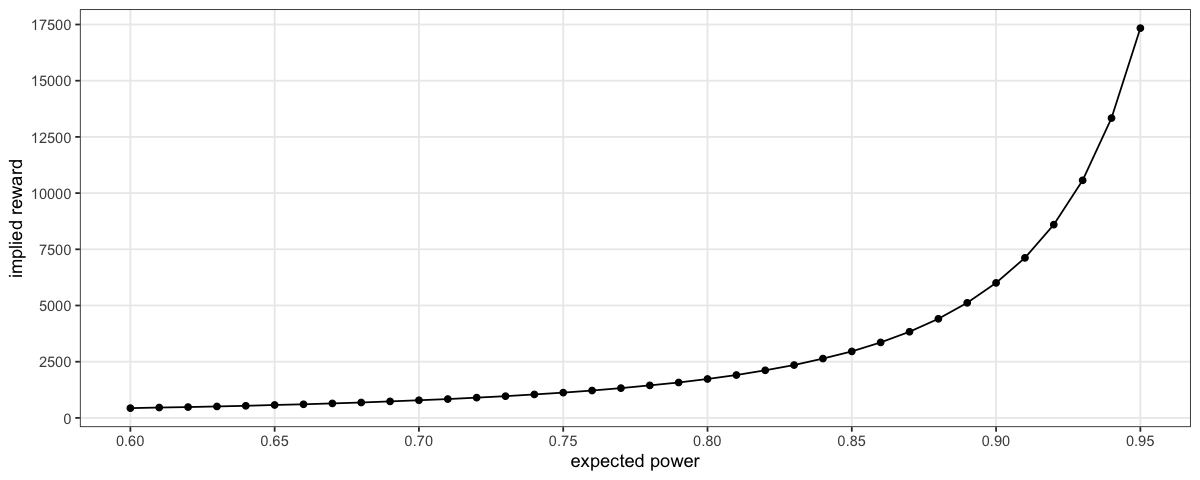

In [25]:
utility <- function(n, lambda) {
    lambda * PoS(prior, n, qnorm(1 - alpha), theta_mcid) - n
}

get_implied_lambda <- function(expected_power) uniroot(
    function(lambda) {
        EP(
            prior,
            round(optimize(function(n) utility(n, lambda), c(10, 1e4), maximum = TRUE)$maximum),
            c = qnorm(1 - alpha),
            mrv = theta_mcid
        ) - expected_power
    },
    c(1, 1e6)
)

tbl_implied_lambda <- tibble(
        power = seq(0.6, 0.95, by = 0.01)
    ) %>%
    mutate(
        n_ep = map_dbl(
            power,
            ~get_n_ep(theta_null, prior, mrv = theta_mcid, pwr = ., alpha = alpha)
        ),
        lambda_implied = map_dbl(power, ~get_implied_lambda(.)$root)
    )

ggplot(tbl_implied_lambda) +
    aes(power, lambda_implied) +
    geom_point() +
    geom_line() +
    scale_x_continuous("expected power", breaks = seq(0.6, 0.95, by = 0.05)) +
    scale_y_continuous("implied reward", breaks = seq(0, 20000, by = 2500)) +
    theme_bw() +
    theme(
        panel.grid.minor = element_blank()
    )

In [26]:
ggsave("../latex/figures/fig7-matched-reward.pdf", width = 8, height = 2.5)

What's the implied reward for 80% expected power?

In [20]:
get_implied_lambda(0.8)$root %>% round

[1] 1732

Get utility maximising sample size for $\lambda = 3333$

In [21]:
optimize(function(n) utility(n, 3333), c(10, 1e4), maximum = TRUE)$maximum %>%
    round

[1] 329

... and the corresponging expected power

In [22]:
EP(prior, 342, c = qnorm(1 - alpha), mrv = theta_mcid)

[1] 0.8642995